In [26]:
# Enhanced ConvLSTM-Based Drought Forecasting

import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score
from tqdm import tqdm

# --- CONFIG --- #
DATA_DIR = "/kaggle/input/water-scarcity/visualization_outputUp"
FEATURES = ['Evap', 'Rainf', 'RootMoist', 'SoilM_0_10cm', 'TVeg']
SEQUENCE_LENGTH = 3
GRID_SHAPE = (88, 130)
BATCH_SIZE = 4
EPOCHS = 10

# --- UTILS --- #
def load_variable_images(var_name, limit=5000):
    print(f"[INFO] Loading images for variable: {var_name}")
    var_dir = os.path.join(DATA_DIR, var_name)
    files = sorted([os.path.join(var_dir, f) for f in os.listdir(var_dir) if f.endswith('.png')])[:limit]
    images = []
    for file in tqdm(files, desc=f"Loading {var_name}"):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (GRID_SHAPE[1], GRID_SHAPE[0]))  # (width, height)

        img_norm = img_resized.astype(np.float32) / 255.0
        images.append(img_norm)
    print(f"[INFO] Finished loading {len(images)} frames for {var_name}")
    return np.array(images)

def preprocess_all_features():
    print("[INFO] Starting full dataset preprocessing...")
    stacked = np.stack([load_variable_images(var) for var in FEATURES], axis=-1)
    print("[INFO] Finished preprocessing all features.")
    return stacked

def normalize_data(data):
    print("[INFO] Normalizing data across time and features...")
    flat = data.reshape(-1, data.shape[-1])
    flat_scaled = MinMaxScaler().fit_transform(flat)
    return flat_scaled.reshape(data.shape)

def create_sequences(data, seq_len, drought_window=3):
    print(f"[INFO] Creating sequences with length: {seq_len}")
    X, y = [], []
    soil_moisture = data[:, :, :, 3]
    threshold = np.percentile(soil_moisture, 20)

    for i in range(len(data) - seq_len - drought_window):
        X_seq = data[i:i+seq_len]
        # Check if avg moisture over next 3 days is below threshold
        next_3_day_avg = np.mean(soil_moisture[i+seq_len:i+seq_len+drought_window], axis=0)
        drought_label = (next_3_day_avg < threshold).astype(np.float32)
        y.append(drought_label[..., np.newaxis])
        X.append(X_seq)

    print(f"[INFO] Created {len(X)} input sequences")
    return np.array(X), np.array(y)

# --- DATA PREP --- #
print("[STAGE] Data Preprocessing")
raw_data = preprocess_all_features()
data_scaled = normalize_data(raw_data)
X, y = create_sequences(data_scaled, SEQUENCE_LENGTH)

# Time-based split (no shuffling)
split_idx = int(0.9 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- MODEL --- #
def build_model():
    print("[INFO] Building ConvLSTM model...")
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, *GRID_SHAPE, len(FEATURES))),
        ConvLSTM2D(16, (3, 3), padding='same', return_sequences=True, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),

        ConvLSTM2D(8, (3, 3), padding='same', return_sequences=False, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),

        Conv2D(1, (3, 3), padding='same', activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("[INFO] Model successfully compiled.")
    return model


[STAGE] Data Preprocessing
[INFO] Starting full dataset preprocessing...
[INFO] Loading images for variable: Evap


Loading Evap: 100%|██████████| 3308/3308 [01:52<00:00, 29.35it/s]


[INFO] Finished loading 3308 frames for Evap
[INFO] Loading images for variable: Rainf


Loading Rainf: 100%|██████████| 3308/3308 [01:43<00:00, 31.98it/s]


[INFO] Finished loading 3308 frames for Rainf
[INFO] Loading images for variable: RootMoist


Loading RootMoist: 100%|██████████| 3308/3308 [01:41<00:00, 32.52it/s]


[INFO] Finished loading 3308 frames for RootMoist
[INFO] Loading images for variable: SoilM_0_10cm


Loading SoilM_0_10cm: 100%|██████████| 3308/3308 [01:46<00:00, 31.13it/s]


[INFO] Finished loading 3308 frames for SoilM_0_10cm
[INFO] Loading images for variable: TVeg


Loading TVeg: 100%|██████████| 3308/3308 [01:44<00:00, 31.59it/s]


[INFO] Finished loading 3308 frames for TVeg
[INFO] Finished preprocessing all features.
[INFO] Normalizing data across time and features...
[INFO] Creating sequences with length: 3
[INFO] Created 3302 input sequences


In [22]:
def setup_gpu():
    # Vérifier les GPU disponibles
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPU disponibles: {len(gpus)}")
    for gpu in gpus:
        print(f" - {gpu}")
    
    if len(gpus) == 0:
        print("Aucun GPU détecté!")
        return None
    
    # Configurer la croissance de mémoire pour éviter d'allouer toute la mémoire immédiatement
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth activé pour {gpu}")
        except RuntimeError as e:
            print(f"Erreur lors de la configuration de la mémoire pour {gpu}: {e}")
    
    # Activer la journalisation des opérations de distribution si nécessaire
    # os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
    # tf.debugging.set_log_device_placement(True)
    
    # Créer une stratégie de distribution MirroredStrategy pour utiliser tous les GPU
    strategy = tf.distribute.MirroredStrategy()
    print(f"Nombre de périphériques dans la stratégie: {strategy.num_replicas_in_sync}")
    
    return strategy

In [23]:
strategy=setup_gpu()

GPU disponibles: 2
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
 - PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Nombre de périphériques dans la stratégie: 2


In [27]:
with strategy.scope():
    
    print("[STAGE] Model Definition")
    model = build_model()
    model.summary()
    
    # --- TRAIN --- #
    print("[STAGE] Training Model")
    early_stop = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=16,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=2
    )

[STAGE] Model Definition
[INFO] Building ConvLSTM model...
[INFO] Model successfully compiled.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_6 (ConvLSTM2D)           │ (None, 3, 88, 130, 16)      │          12,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 88, 130, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 88, 130, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)           │ (None, 88, 130, 8)          │           6,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 88, 130, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 88, 130, 8)          │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 88, 130, 1)          │              73 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,273 (75.29 KB)

 Trainable params: 19,225 (75.10 KB)

 Non-trainable params: 48 (192.00 B)

[STAGE] Training Model
Epoch 1/10


E0000 00:00:1746351764.218821      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/gradient_tape/sequential_3_1/dropout_7_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


149/149 - 24s - 158ms/step - accuracy: 0.8922 - loss: 0.4150 - val_accuracy: 0.9707 - val_loss: 0.1785
Epoch 2/10
149/149 - 14s - 91ms/step - accuracy: 0.9849 - loss: 0.0824 - val_accuracy: 0.9707 - val_loss: 0.1031
Epoch 3/10
149/149 - 14s - 92ms/step - accuracy: 0.9934 - loss: 0.0304 - val_accuracy: 0.9808 - val_loss: 0.0458
Epoch 4/10
149/149 - 14s - 91ms/step - accuracy: 0.9963 - loss: 0.0165 - val_accuracy: 0.9966 - val_loss: 0.0111
Epoch 5/10
149/149 - 13s - 89ms/step - accuracy: 0.9975 - loss: 0.0105 - val_accuracy: 0.9993 - val_loss: 0.0041
Epoch 6/10
149/149 - 13s - 88ms/step - accuracy: 0.9983 - loss: 0.0073 - val_accuracy: 0.9997 - val_loss: 0.0025
Epoch 7/10
149/149 - 13s - 89ms/step - accuracy: 0.9987 - loss: 0.0054 - val_accuracy: 0.9998 - val_loss: 0.0016
Epoch 8/10
149/149 - 13s - 89ms/step - accuracy: 0.9990 - loss: 0.0041 - val_accuracy: 0.9999 - val_loss: 0.0011
Epoch 9/10
149/149 - 13s - 90ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9999 - val_loss: 

In [28]:


# --- EVALUATE --- #
print("[STAGE] Evaluating Model")
loss, acc = model.evaluate(X_test, y_test)
print(f"[RESULT] Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

# --- METRICS --- #
print("[STAGE] Classification Metrics")
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.7).astype(np.float32)

print(classification_report(y_test.flatten(), y_pred_binary.flatten(), digits=4))
print("AUC Score:", roc_auc_score(y_test.flatten(), y_pred.flatten()))


[STAGE] Evaluating Model


E0000 00:00:1746352037.693218      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'sequential_3_1/conv_lstm2d_7_1/while/sequential_3_1/conv_lstm2d_7_1/zeros_switch/_81-0-TransposeNHWCToNCHW-LayoutOptimizer' -> 'sequential_3_1/conv_lstm2d_7_1/while/sequential_3_1/conv_lstm2d_7_1/zeros_switch/_81', 'sequential_3_1/conv_lstm2d_7_1/while/body/_58/sequential_3_1/conv_lstm2d_7_1/while/conv_lstm_cell_1/mul' -> 'sequential_3_1/conv_lstm2d_7_1/while/body/_58/sequential_3_1/conv_lstm2d_7_1/while/conv_lstm_cell_1/add_7', 'sequential_3_1/conv_lstm2d_6_1/while/body/_15/sequential_3_1/conv_lstm2d_6_1/while/conv_lstm_cell_1/mul' -> 'sequential_3_1/conv_lstm2d_6_1/while/body/_15/sequential_3_1/conv_lstm2d_6_1/while/conv_lstm_cell_1/add_7', 'sequential_3_1/conv_lstm2d_6_1/while/sequential_3_1/conv_lstm2d_6_1/zeros_switch/_38-0-TransposeNHWCToNCHW-LayoutOptimizer' -> 'sequential_3_1/conv_lstm2d_6_1/while/sequentia

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 6.4831e-04
[RESULT] Test Loss: 0.0006, Test Accuracy: 1.0000
[STAGE] Classification Metrics
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000   3675557
         1.0     0.9994    0.9990    0.9992    111083

    accuracy                         1.0000   3786640
   macro avg     0.9997    0.9995    0.9996   3786640
weighted avg     1.0000    1.0000    1.0000   3786640

AUC Score: 0.999993928275308


[STAGE] Visualizing Training History


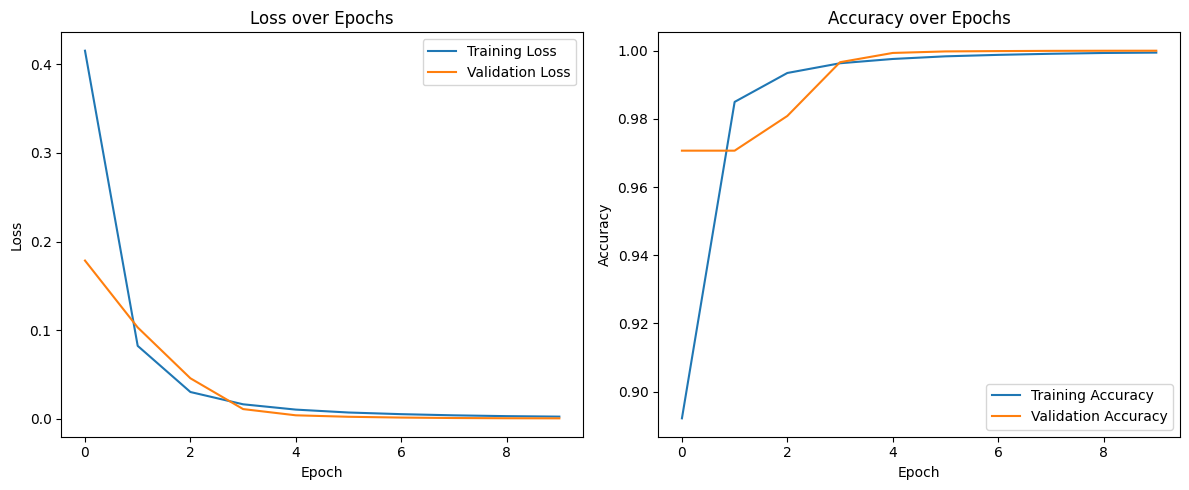

In [29]:

import matplotlib.pyplot as plt
# --- VISUALIZE --- #
def plot_training_history(history):
    print("[STAGE] Visualizing Training History")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [30]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
print("[STAGE] Generating Classification Report")
y_pred = model.predict(X_test) > 0.7
print(classification_report(y_test.flatten(), y_pred.flatten()))


[STAGE] Generating Classification Report
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   3675557
         1.0       1.00      1.00      1.00    111083

    accuracy                           1.00   3786640
   macro avg       1.00      1.00      1.00   3786640
weighted avg       1.00      1.00      1.00   3786640



In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_drought_overlay(model, input_sequence, base_image, threshold=0.5):
    """
    Args:
        model: Trained ConvLSTM Keras model.
        input_sequence: Numpy array of shape (sequence_length, 64, 64, num_features).
        base_image: Grayscale base image (64x64) to overlay drought on (e.g., SoilM_0_10cm).
        threshold: Float in [0,1] to binarize the prediction.
    
    Returns:
        overlayed_image: RGB image with drought highlighted in red.
    """
    # Ensure input shape is correct
    input_sequence = np.expand_dims(input_sequence, axis=0)  # (1, seq_len, 64, 64, 5)
    
    # Predict drought map
    prediction = model.predict(input_sequence)[0, :, :, 0]  # Shape: (64, 64)

    # Binarize output
    drought_mask = (prediction > threshold).astype(np.uint8)

    # Convert grayscale base image to RGB
    base_rgb = cv2.cvtColor((base_image * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Create red mask for drought
    red_mask = np.zeros_like(base_rgb)
    red_mask[drought_mask == 1] = [0, 0, 255]  # BGR Red

    # Overlay drought on base image
    overlayed = cv2.addWeighted(base_rgb, 1.0, red_mask, 0.5, 0)

    return overlayed, prediction, drought_mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


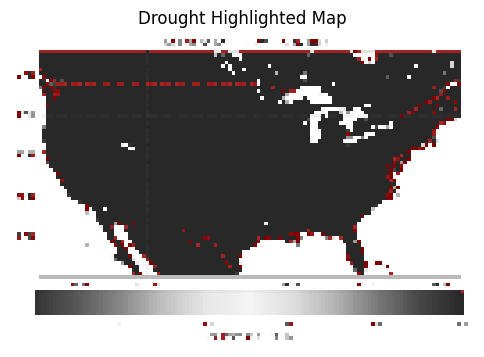

In [32]:
# Use the last frame from a sample test sequence
sample_input = X_test[0]  # Shape: (20, 64, 64, 5)

# Use the last frame's SoilM_0_10cm as the background image
base = sample_input[-1, :, :, 3]  # Use channel index 3 (SoilM_0_10cm)

# Generate drought visualization
drought_overlay, raw_pred, mask = generate_drought_overlay(model, sample_input, base)

# Display
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(drought_overlay, cv2.COLOR_BGR2RGB))
plt.title("Drought Highlighted Map")
plt.axis("off")
plt.show()


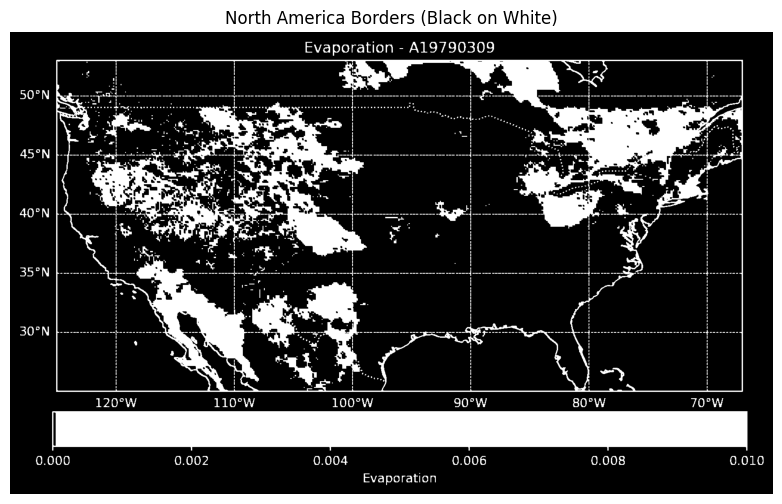

Image saved to drought_predictions.png


In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def highlight_edges(base_path):
    # Load image and convert to RGB
    base_img = cv2.imread(base_path)
    base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale and threshold to isolate borders
    gray = cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY)
    _, borders = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)  # Get existing white borders
    
    # Create white background image
    white_img = np.ones_like(base_img) * 255
    
    # Apply inverted borders (black edges)
    white_img[borders == 255] = [0, 0, 0]
    
    # Optional: Clean up small artifacts with morphological operations
    kernel = np.ones((2,2), np.uint8)
    borders_cleaned = cv2.morphologyEx(borders, cv2.MORPH_OPEN, kernel)
    white_img[borders_cleaned == 255] = [0, 0, 0]
    
    return white_img

# Example usage
output_img = highlight_edges("/kaggle/input/water-scarcity/visualization_outputUp/Evap/A19790309.png")
plt.figure(figsize=(10, 6))
plt.imshow(output_img)
plt.axis('off')
plt.title("North America Borders (Black on White)")
plt.show()
# Add this after displaying the image (or instead of displaying)

output_path = "drought_predictions.png"  # Change to your desired path
cv2.imwrite(output_path, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))  # OpenCV uses BGR format
print(f"Image saved to {output_path}")

In [34]:
def process_and_overlay(base_path, model_output, threshold=0.5):
    # Read and process base image
    base_img = cv2.imread(base_path)
    base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale and threshold to isolate borders
    gray = cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY)
    _, borders = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)  # Get white borders
    
    # Create black background with white borders
    processed_img = np.zeros_like(base_img)
    processed_img[borders == 255] = [255, 255, 255]  # White borders
    
    # Process model output
    height, width = processed_img.shape[:2]
    drought_mask = (model_output > threshold).astype(np.uint8)
    drought_mask_upscaled = cv2.resize(drought_mask, (width, height), interpolation=cv2.INTER_NEAREST)
    
    # Create red dots (you can adjust the kernel size for dot size)
    kernel = np.ones((3, 3), np.uint8)  # Smaller kernel for dots
    dilated_mask = cv2.dilate(drought_mask_upscaled, kernel)
    
    # Apply red color to the predicted areas
    processed_img[dilated_mask == 1] = [255, 0, 0]  # Red dots
    
    return processed_img


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step


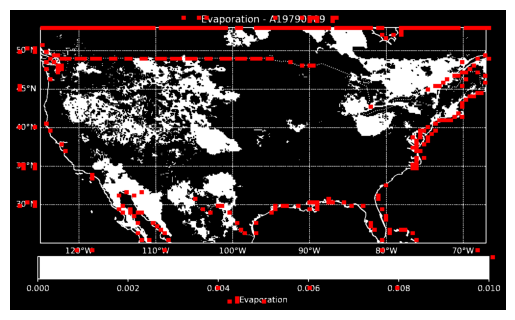

In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def upscale_and_overlay(base_path, model_output, threshold=0.5):
    base_img = cv2.imread(base_path)
    base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)

    height, width = base_img.shape[:2]
    drought_mask = (model_output > threshold).astype(np.uint8)
    drought_mask_upscaled = cv2.resize(drought_mask, (width, height), interpolation=cv2.INTER_NEAREST)

    red_overlay = np.zeros_like(base_img)
    red_overlay[:, :] = [255, 0, 0]

    mask_3ch = np.repeat(drought_mask_upscaled[:, :, np.newaxis], 3, axis=2)
    result = np.where(mask_3ch == 1, red_overlay, base_img)

    return result

# 🧪 Simulate a dummy model output (random 64x64 map)
# Assuming your preprocessed input is in variable `input_sequence`
model_output = model.predict(X_train)[0, :, :, 0]
output_img = process_and_overlay("drought_predictions.png", model_output)
plt.imshow(output_img)
plt.axis('off')
plt.show()


In [40]:
model.save('drought-prediction.h5')
